In [1]:


import numpy as np  
import pandas as pd 
import tensorflow as tf

import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-06-09 21:24:47.054645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 21:24:47.054752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 21:24:47.177565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/balanced-data/balanced_data.csv
/kaggle/input/dataset/test_essays.csv
/kaggle/input/dataset/train_essays.csv
/kaggle/input/dataset/train_v2_drcat_02.csv
/kaggle/input/test-dataset/data.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
org_data = pd.read_csv("/kaggle/input/dataset/train_essays.csv")
new_data = pd.read_csv("/kaggle/input/dataset/train_v2_drcat_02.csv")
test_data = pd.read_csv("/kaggle/input/dataset/test_essays.csv")
data11 = pd.read_csv("/kaggle/input/test-dataset/data.csv")

# Explore the dataset


In [3]:
org_data = org_data[["text", "generated"]]
org_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


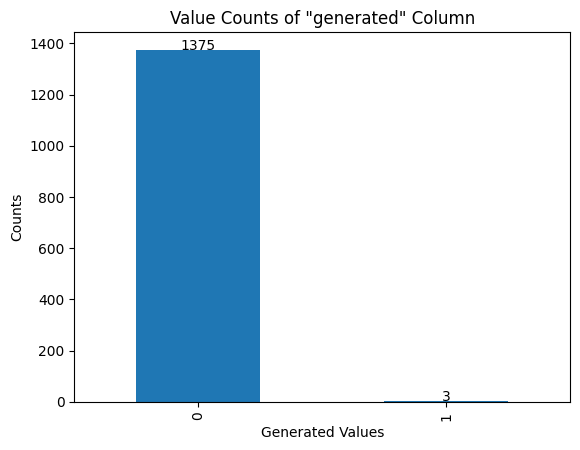

In [4]:
import matplotlib.pyplot as plt

# Assuming org_data is a DataFrame and 'generated' is one of its columns
org_data_generated_counts = org_data["generated"].value_counts()

# Plot a bar chart of the value counts of the original data
org_data_generated_counts.plot(kind='bar')

# Add count labels above each bar
for i, count in enumerate(org_data_generated_counts):
    plt.text(i, count + 0.1, str(count), ha='center')

# Add labels and title
plt.xlabel('Generated Values')
plt.ylabel('Counts')
plt.title('Value Counts of "generated" Column')

# Show the plot
plt.show()




In [5]:
new_data = new_data[["text", "label"]].rename(columns={'text':'text', 'label':'generated'})
new_data

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


The test dataset contains only 3 essays. The length of each essay is very small (12 characters).

In [6]:
org_data.drop_duplicates(subset=['text'], inplace=True), new_data.drop_duplicates(subset=['text'], inplace=True)

(None, None)

In [7]:
positive = new_data.loc[new_data['generated'] == 1]
positive

,text,generated
25996,"In recent years, technology has had a profoun...",1
25997,I strongly believe that meditation and mindful...,1
25998,One way school administrators can attempt to c...,1
25999,While summer is meant as a break from the regu...,1
26000,The use of Facial Action Coding System (FACS) ...,1
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [8]:
negative = new_data.loc[new_data['generated'] == 0]
negative

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
43479,There has been a fuss about the Elector Colleg...,0
43480,Limiting car usage has many advantages. Such a...,0
43481,There's a new trend that has been developing f...,0
43482,As we all know cars are a big part of our soci...,0


In [9]:
text_overlap_of_positive = positive["text"].isin(org_data["text"])
print(text_overlap_of_positive.sum())

positive = positive[~text_overlap_of_positive]

3


In [9]:
text_overlap_of_negative = negative["text"].isin(org_data["text"])
print(text_overlap_of_negative.sum())

negative = negative[~text_overlap_of_negative]

1375


In [10]:
augmented_data  = pd.concat([org_data, positive, negative.sample(8618)])
augmented_data  = augmented_data .sample(frac=1).reset_index(drop=True)
augmented_data

,text,generated
0,Today majority of humans own or use a cell pho...,0
1,"As a child, I was fortunate enough to have a ...",1
2,Students should have a summer project created ...,0
3,Advantages of Limiting Car Usage\n\nLimiting c...,1
4,First impressions are often incredibly influen...,1
...,...,...
27488,"My mom always tells me ""never give up, keep g...",1
27489,The future is a curious thing - predictable i...,1
27490,Working in a group offers the advantage of inc...,1
27491,A positive attitude is one of the most importa...,1


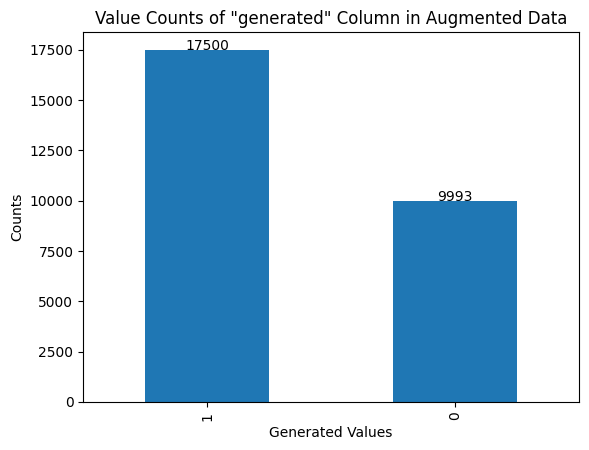

In [11]:
import matplotlib.pyplot as plt

# Assuming org_data is a DataFrame and 'generated' is one of its columns
augmented_generated_value_counts = augmented_data["generated"].value_counts()
# Plot a bar chart of the augmented generated value counts
augmented_generated_value_counts.plot(kind='bar')

# Add count labels above each bar
for i, count in enumerate(augmented_generated_value_counts):
    plt.text(i, count + 0.1, str(count), ha='center')

# Add labels and title
plt.xlabel('Generated Values')
plt.ylabel('Counts')
plt.title('Value Counts of "generated" Column in Augmented Data')

# Show the plot
plt.show()


We need to balance the class distribution

# Text Cleaning

In [12]:
import unicodedata

def Clean(text):
    # Normaliser le texte en utilisant la forme de normalisation NFKD de l'Unicode
    text = unicodedata.normalize('NFKD', text)
    # Convertir le texte en minuscules
    text = text.lower()
    # Supprimer tous les caractères qui ne sont pas des lettres, des espaces ou des ponctuations
    text = re.sub(r'[^a-z.?!,¿ ]', '', text)
    # Ajouter des espaces autour des ponctuations pour séparer les mots
    text = re.sub(r'([.?!,¿])', r' \1 ', text)
    # Supprimer les espaces en début et en fin de texte
    text = text.strip()
    # Remplacer les séquences de points de suspension par un seul espace
    text = re.sub(r'\.{3,}', ' ', text)
    # Ajouter des espaces autour du texte pour garantir une séparation correcte des mots
    text = ' ' + text + ' '
    return text
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [14]:
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

On a tester nos modèles avec et sans suppression de stopwords pour voir comment cela affecte les performanceset.Et on a trouver que cela a fait réduire la performance en supprimant des informations utiles.

In [13]:
import pandas as pd

# Supprimer les doublons pour éviter tout chevauchement
org_data.drop_duplicates(subset=['text'], inplace=True)
new_data.drop_duplicates(subset=['text'], inplace=True)

# Sous-échantillonner les données avec l'étiquette 1 pour avoir 9800 exemples
positive_subset = new_data[new_data['generated'] == 1].sample(n=9800, random_state=42)

# Sous-échantillonner les données avec l'étiquette 0 pour avoir également 9800 exemples
negative_subset = new_data[new_data['generated'] == 0].sample(n=9800, random_state=42)

# Concaténer les deux sous-ensembles
balanced_data = pd.concat([positive_subset, negative_subset])

# Mélanger les données pour mélanger les étiquettes 0 et 1
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Appliquer la fonction de nettoyage de texte
balanced_data['clean_text'] = balanced_data['text'].apply(clean_text)

# Appliquer la fonction de suppression des stopwords à la colonne 'clean_text'
#balanced_data['clean_text_without_stopwords'] = balanced_data['clean_text'].apply(remove_stopwords)

# Afficher les premières lignes pour vérification
print(balanced_data.head())

                                                text  generated  \
0  I strongly disagree with the idea that all stu...          0   
1  Limiting car usage has many benefits for moder...          1   
2  Well, personally i feel as though "distant lea...          0   
3  Have you ever been so stuck on a choice, that ...          0   
4  Have you ever wondered what your life would be...          0   

                                          clean_text  
0  i strongly disagree with the idea that all stu...  
1  limiting car usage has many benefits for moder...  
2  well personally i feel as though distant learn...  
3  have you ever been so stuck on a choice that y...  
4  have you ever wondered what your life would be...  


generated
0    9800
1    9800
Name: count, dtype: int64


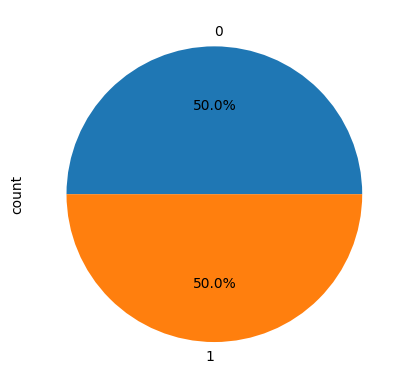

In [14]:
# Calculate the counts of each unique value in the "generated" column of augmented data
balanced_data_value_counts = balanced_data["generated"].value_counts()

# Print the augmented generated value counts
print(balanced_data_value_counts)

# Plot a pie chart of the augmented generated value counts with percentage labels
balanced_data_value_counts.plot.pie(autopct='%1.1f%%');

ajouter des texts

In [15]:
# Supprimer les doublons pour éviter tout chevauchement
org_data.drop_duplicates(subset=['text'], inplace=True)
new_data.drop_duplicates(subset=['text'], inplace=True)

# Sous-échantillonner les données avec l'étiquette 1 pour avoir 10k exemples
positive_subset = new_data[new_data['generated'] == 1].sample(n=15000, random_state=42)

# Sous-échantillonner les données avec l'étiquette 0 pour avoir également 10k exemples
negative_subset = new_data[new_data['generated'] == 0].sample(n=15000, random_state=42)

# Concaténer les deux sous-ensembles avec balanced_data existant
balanced_data = pd.concat([balanced_data, positive_subset, negative_subset])

# Mélanger les données pour mélanger les étiquettes 0 et 1
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Appliquer la fonction de nettoyage de texte
balanced_data['clean_text'] = balanced_data['text'].apply(clean_text)

# Appliquer la fonction de suppression des stopwords à la colonne 'clean_text'
#balanced_data['clean_text_without_stopwords'] = balanced_data['clean_text'].apply(remove_stopwords)

# Afficher les premières lignes pour vérification
print(balanced_data.head())

                                                text  generated  \
0  When it comes down to air pollution cars are o...          0   
1  Let me ask you this question What's better the...          0   
2  Sure, here's my essay:\n\nOne of the best ways...          1   
3  Welcome to 2016. Finally, technolgy had gotten...          0   
4  I agree with this decision, because it makes s...          0   

                                          clean_text  
0  when it comes down to air pollution cars are o...  
1  let me ask you this question whats better then...  
2  sure heres my essay one of the best ways to sp...  
3  welcome to finally technolgy had gotten smarte...  
4  i agree with this decision because it makes sc...  


In [16]:
X, y = balanced_data ["clean_text"], balanced_data ["generated"]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y)

# **Training models : binary text classification**

In [18]:
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_curve, auc
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  
from sklearn.naive_bayes import MultinomialNB 

# Functions (TF-IDF, Evaluates the trained model and Plots the ROC curve).

In [19]:

vectorizer = TfidfVectorizer(tokenizer=get_tokenizer("basic_english"), token_pattern=None)

def vectorize_text(X_train, X_val):
    """
    Vectorizes the text data using TF-IDF.
    """
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_val_vectorized = vectorizer.transform(X_val)
    return X_train_vectorized, X_val_vectorized

In [20]:
def evaluate_model(model, X_val, y_val):
    """
    Evaluates the trained model on the validation data and returns classification report.
    """
    predictions = model.predict(X_val)
    report = classification_report(y_val, predictions)
    return report

In [21]:
def plot_roc_auc(model, X_val, y_val, ax):
    """
    Plots the ROC curve for a given model.

    Parameters:
    model : object
        The trained classification model.
    X_val : array-like or sparse matrix, shape (n_samples, n_features)
        Validation data.
    y_val : array-like, shape (n_samples,)
        True binary labels in range {0, 1} or {-1, 1}.
    ax : matplotlib Axes object
        The axes to plot the ROC curve on.

    Returns:
    None
    """
    # Predict probabilities
    y_score = model.predict_proba(X_val)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    ax.plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (type(model).__name__, roc_auc))

    return ax

# Fit Models LogisticRegression, MultinomialNB, GradientBoostingClassifier

LogisticRegression is trained in 7.107357025146484 seconds
MultinomialNB is trained in 0.0583195686340332 seconds
GradientBoostingClassifier is trained in 259.4841511249542 seconds


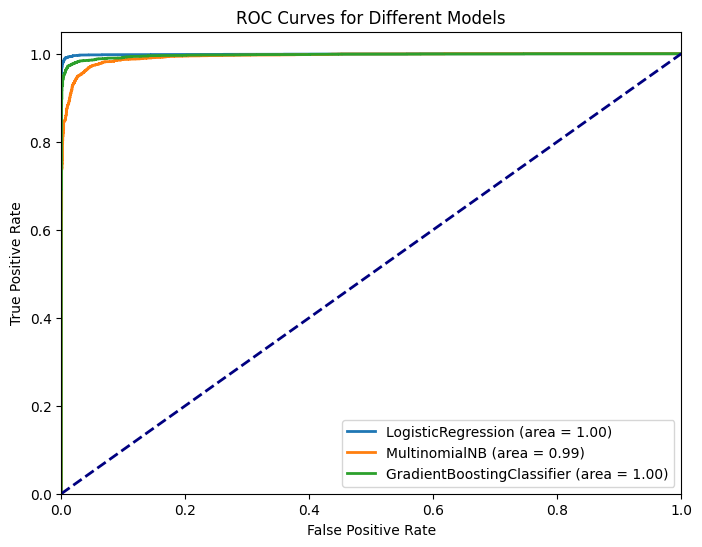

In [24]:


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB  # Importation du classificateur Naive Bayes multinomial
from sklearn.linear_model import LogisticRegression  # Importation du classificateur de régression logistique

# Vectoriser les données
X_train_vectorized, X_val_vectorized = vectorize_text(X_train, X_val)

# Ajouter les classificateurs à la liste des modèles avec probability=True
models = [LogisticRegression(), MultinomialNB(), GradientBoostingClassifier(), ]

# Initialiser un dictionnaire pour stocker les rapports des modèles
model_reports = {}

# Créer la figure et les axes pour la visualisation
fig, ax = plt.subplots(figsize=(8, 6))

# Boucle à travers chaque modèle
for model in models:
    # Début du temps d'entraînement
    start = time.time()

    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train_vectorized, y_train)

    # Fin du temps d'entraînement
    end = time.time()

    # Afficher la courbe ROC pour le modèle
    ax = plot_roc_auc(model, X_val_vectorized, y_val, ax)

    # Évaluer le modèle sur les données de validation et obtenir le rapport de classification
    report = evaluate_model(model, X_val_vectorized, y_val)

    # Enregistrer le rapport dans le dictionnaire avec le nom du modèle comme clé
    model_name = type(model).__name__
    model_reports[model_name] = report

    # Imprimer le temps d'entraînement
    print(f'{model_name} is trained in {end-start} seconds')

# Tracer la ligne diagonale (y=x) pour la comparaison
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Limiter les axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Ajouter des étiquettes et un titre
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Different Models')

# Ajouter une légende
ax.legend(loc="lower right")

# Afficher la figure
plt.show()


# CNN

In [25]:
# Load the dataset
file_path = '/kaggle/input/dataset/train_v2_drcat_02.csv'
data = pd.read_csv(file_path, on_bad_lines='skip', engine='python')

# Inspect the first few rows of the dataset
data

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
file_path1 = '/kaggle/input/dataset/train_v2_drcat_02.csv'
file_path2 = '/kaggle/input/test-dataset/data.csv'
data1 = pd.read_csv(file_path1, on_bad_lines='skip', engine='python')
data2 = pd.read_csv(file_path2, on_bad_lines='skip', engine='python')

# Ensure there are no missing values and that labels are integers
data1.dropna(subset=['text', 'label'], inplace=True)
data1['label'] = data1['label'].astype(int)

data2.dropna(subset=['text', 'generated'], inplace=True)
data2['label'] = data2['generated'].astype(int)

# Combine the datasets
combined_data = pd.concat([data1, data2])

# Extract texts and labels
texts = combined_data['text'].values
labels = combined_data['label'].values

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
A = pad_sequences(sequences, maxlen=maxlen)
B = np.array(labels)

# Split the dataset into training (80%) and testing (20%) sets
A_train, A_test, B_train, B_test = train_test_split(A, B, test_size=0.2, random_state=42)

# Improved Model Architecture
def create_improved_model(vocab_size=10000, embedding_dim=128, maxlen=100):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Train the improved model
improved_model = create_improved_model()
improved_model.fit(A_train, B_train, epochs=10, batch_size=32, validation_split=0.2)

# Save the improved model
improved_model.save('improved_text_classification_model.h5')




/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
  61/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5461 - loss: 0.6887

I0000 00:00:1717968996.323815     275 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6075 - loss: 0.6510 - val_accuracy: 0.8559 - val_loss: 0.3454
Epoch 2/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8619 - loss: 0.3254 - val_accuracy: 0.9256 - val_loss: 0.1873
Epoch 3/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9279 - loss: 0.1871 - val_accuracy: 0.9388 - val_loss: 0.1518
Epoch 4/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9528 - loss: 0.1310 - val_accuracy: 0.9434 - val_loss: 0.1392
Epoch 5/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9671 - loss: 0.0953 - val_accuracy: 0.9479 - val_loss: 0.1377
Epoch 6/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9793 - loss: 0.0670 - val_accuracy: 0.9481 - val_loss: 0.1416
Epoch 7/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9858 - loss: 0.0486 - val_accuracy: 0.9492 - val_loss: 0.1474
Epoch 8/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9920 - loss: 0.0323 - val_accura

# Confusion matrices et Evaluation CNN

343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precision: 0.9336846728151076
Recall: 0.9357394366197183
F1 Score: 0.9347109254781271
Accuracy: 0.9458720612356479
Confusion Matrix:
[[6128  302]
 [ 292 4252]]


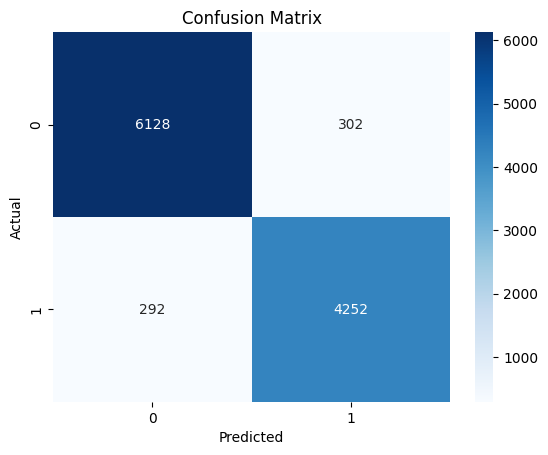

In [27]:
# Function to evaluate the model on the dataset and plot confusion matrix
def evaluate_model_on_dataset(model, A_test, B_test):
    # Make predictions
    B_pred_prob = model.predict(A_test)
    B_pred = (B_pred_prob > 0.5).astype(int).flatten()

    # Calculate evaluation metrics
    precision = precision_score(B_test, B_pred)
    recall = recall_score(B_test, B_pred)
    f1 = f1_score(B_test, B_pred)
    accuracy = accuracy_score(B_test, B_pred)
    conf_matrix = confusion_matrix(B_test, B_pred)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the improved model on the test set
evaluate_model_on_dataset(improved_model, A_test, B_test)

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt

# Load the tokenizer (Assuming it's already fitted on the training data)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)  # Use the same 'texts' variable from the training phase

# Load the trained model
model = tf.keras.models.load_model('improved_text_classification_model.h5')

def evaluate_model_on_dataset(dataset_path):
    # Load the dataset
    data = pd.read_csv(dataset_path, on_bad_lines='skip', engine='python')

    # Ensure there are no missing values and that labels are integers
    data.dropna(subset=['text', 'generated'], inplace=True)
    data['generated'] = data['generated'].astype(int)

    # Extract texts and labels
    texts = data['text'].values
    labels = data['generated'].values

    # Preprocess the text data
    sequences = tokenizer.texts_to_sequences(texts)
    maxlen = 100  # Ensure this matches the maxlen used during training
    A = pad_sequences(sequences, maxlen=maxlen)
    B = np.array(labels)

    # Make predictions
    B_pred_prob = model.predict(A)
    B_pred = (B_pred_prob > 0.5).astype(int).flatten()

    # Calculate evaluation metrics
    precision = precision_score(B, B_pred)
    recall = recall_score(B, B_pred)
    f1 = f1_score(B, B_pred)
    accuracy = accuracy_score(B, B_pred)
    conf_matrix = confusion_matrix(B, B_pred)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


# Test sur balanced_data

613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precision: 0.9954830099579098
Recall: 0.9894897959183674
F1 Score: 0.9924773553042322
Accuracy: 0.9925
Confusion Matrix:
[[9756   44]
 [ 103 9697]]


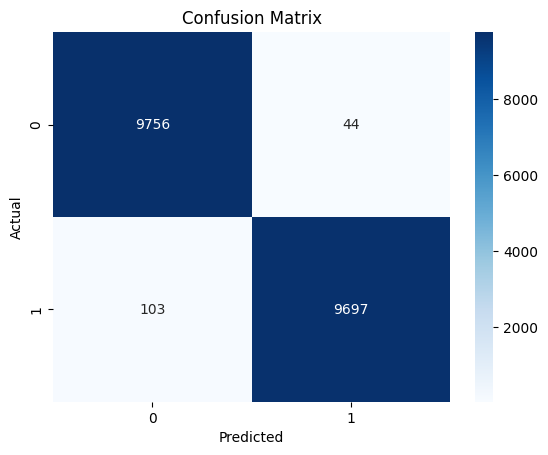

In [29]:
# # Example usage
dataset_path = '/kaggle/input/balanced-data/balanced_data.csv'  # Replace with the actual dataset path
evaluate_model_on_dataset(dataset_path)


# Submission

In [30]:
test_data

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [31]:
def create_predictor(model):
  def predict_proba(df):
      df = df[['id','text']]
      ids = df.id
      x = df.text
      sequences = tokenizer.texts_to_sequences(x)
      maxlen = 100  # Ensure this matches the maxlen used during training
      A = pad_sequences(sequences, maxlen=maxlen)
    
      preds = model.predict(A)
      preds = [item for sublist in preds for item in sublist]
      result_df = pd.DataFrame({'id': ids, 'generated': preds})
      return result_df
    
  return predict_proba

clf = create_predictor(improved_model)

submission_df = clf(test_data)


submission_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


,id,generated
0,0000aaaa,0.392725
1,1111bbbb,0.381588
2,2222cccc,0.381588


In [32]:
submission_df.to_csv('submission.csv', index=False)

# Classification reports ML

In [33]:
for model_name, report in model_reports.items():
    print(f"Classification Report for {model_name}:\n{report}\n")

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4960
           1       1.00      0.99      0.99      4960

    accuracy                           0.99      9920
   macro avg       0.99      0.99      0.99      9920
weighted avg       0.99      0.99      0.99      9920


Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4960
           1       0.97      0.95      0.96      4960

    accuracy                           0.96      9920
   macro avg       0.96      0.96      0.96      9920
weighted avg       0.96      0.96      0.96      9920


Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4960
           1       0.99      0.97      0.98      4960

    accuracy                           

# Confusion matrices et Evaluation ML

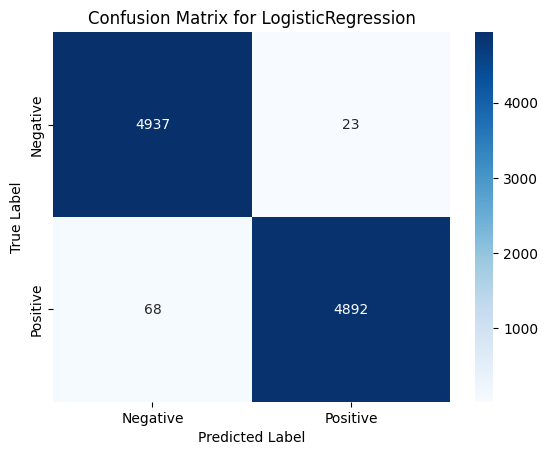

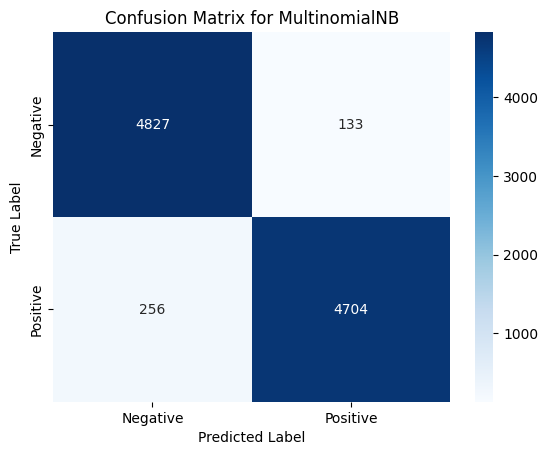

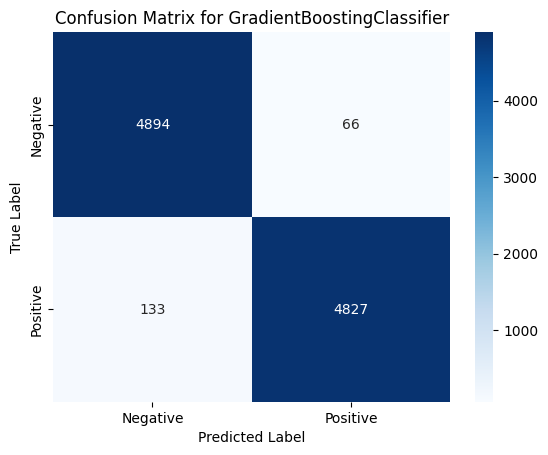

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(model, X_val, y_val):
    predictions = model.predict(X_val)
    cm = confusion_matrix(y_val, predictions)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.show()

# Boucle pour afficher les matrices de confusion pour chaque modèle
for model in models:
    plot_confusion_matrix(model, X_val_vectorized, y_val)